## Import libraries

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set()
%matplotlib inline

## Data visualization on a few samples

Let's look at 5 random controls and 5 random PanIN samples. This is only to start to get an idea of what the spectrometry data looks like. 

First things first. The data files have very long names. I couldn't find out if thesse names were associated with some kind of information. I will start off by renaming all files in each folder to something more digestible. I may have to revisit this step if the file name do in fact, turn out to be important. Only one way to find out. 

In [36]:
import os

# Switch to folder with 'control' files
os.chdir(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\02-Control')

# Check if I'm in the right directory
#print(os.getcwd())

# Rename files in the Control folder
for file in os.listdir():
    #print(file)     # Get file names
    #print(os.path.splitext(file))     # Separate file name from extension
    file_name, file_ext = os.path.splitext(file)     # Store the file name and extensions
    new_name = '{}{}'.format(file_name.split('_')[0], file_ext)     # Grab the first identifying number for each file
    #print(new_name)     # Confirm that the name we have the name we want
    os.rename(file,new_name)     # Rename files
    
# Rename files in the PanIN folder
os.chdir(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\03-PanIN')
for file in os.listdir():
    file_name, file_ext = os.path.splitext(file)     # Store the file name and extensions
    new_name = '{}{}'.format(file_name.split('_')[0], file_ext)     # Grab the first identifying number for each file
    #print(new_name)     # Confirm that the name we have the name we want
    os.rename(file,new_name)     # Rename files

Text(0.5, 1.0, 'Control Samples')

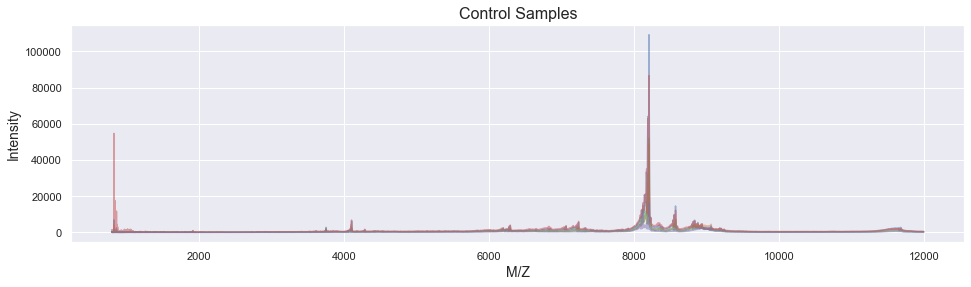

In [37]:
# Import a Control sample
cs1 = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\02-Control\151.csv')
cs2 = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\02-Control\164.csv')
cs3 = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\02-Control\245.csv')
cs4 = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\02-Control\376.csv')
cs5 = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\02-Control\428.csv')

# Plot the mass spectrum for Control samples
plt.figure(figsize=[16,4])
plt.plot(cs1['M/Z'], cs1['Intensity'], alpha=0.5)
plt.plot(cs2['M/Z'], cs2['Intensity'], alpha=0.5)
plt.plot(cs3['M/Z'], cs3['Intensity'], alpha=0.5)
plt.plot(cs4['M/Z'], cs4['Intensity'], alpha=0.5)
plt.plot(cs5['M/Z'], cs5['Intensity'], alpha=0.5)
plt.xlabel('M/Z', fontsize=14)
plt.ylabel('Intensity', fontsize=14)
plt.title('Control Samples', fontsize=16)

The spectrometry files seem to show consistent peaks for the 5 random control samples. Let's try the same for the PanIN samples.

Text(0.5, 1.0, 'Control Samples')

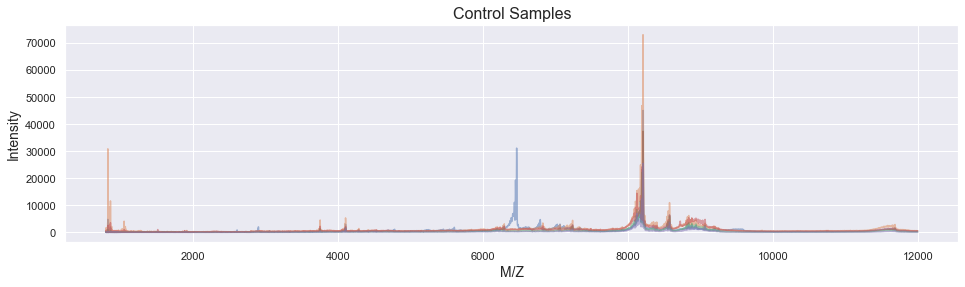

In [38]:
#### Import a Control sample
p1 = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\03-PanIN\178.csv')
p2 = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\03-PanIN\221.csv')
p3 = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\03-PanIN\334.csv')
p4 = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\03-PanIN\369.csv')
p5 = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\03-PanIN\403.csv')

# Plot the mass spectrum for Control samples
plt.figure(figsize=[16,4])
plt.plot(p1['M/Z'], p1['Intensity'], alpha=0.5)
plt.plot(p2['M/Z'], p2['Intensity'], alpha=0.5)
plt.plot(p3['M/Z'], p3['Intensity'], alpha=0.5)
plt.plot(p4['M/Z'], p4['Intensity'], alpha=0.5)
plt.plot(p5['M/Z'], p5['Intensity'], alpha=0.5)
plt.xlabel('M/Z', fontsize=14)
plt.ylabel('Intensity', fontsize=14)
plt.title('Control Samples', fontsize=16)

There is an unexpected peak for one sample that we randomly chose, but overall the peaks still seem fairly consistent. Now let's compare the controls and PanIN samples

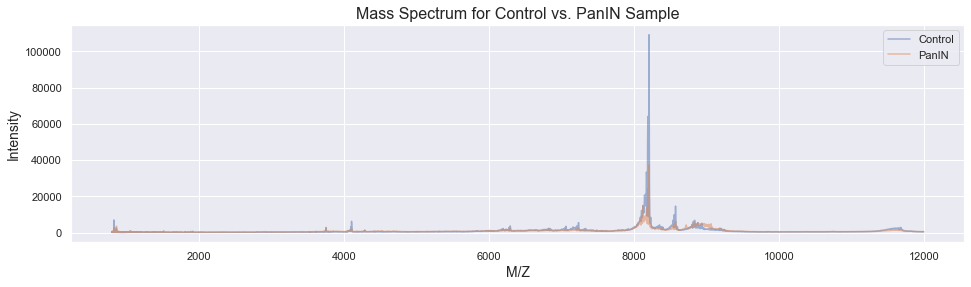

In [47]:
plt.figure(figsize=[16,4])
plt.plot(cs1['M/Z'], cs1['Intensity'], alpha=0.5, label='Control')
plt.plot(p4['M/Z'], p4['Intensity'], alpha=0.5, label='PanIN')
plt.xlabel('M/Z', fontsize=14)
plt.ylabel('Intensity', fontsize=14)
plt.title('Mass Spectrum for Control vs. PanIN Sample', fontsize=16)
plt.legend()
plt.savefig(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Figures\Mass Spectrum.png')

If we were to just try to visually compare the spectra for a control and a PanIN sample, it would be quite difficult to identify differences. This is why we are trying to train a model to do this for us! 